In [1]:
import pandas as pd
import pickle
from PIL import Image
import numpy as np
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shelve
import math
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pickle5 as pickle
import scipy.io
from scipy.stats import sem
import dataframe_image as dfi

In [2]:
##dataloader
from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):
    def __init__(self, txt_path, img_dir, transforms = None):
        df = pickle.load(open(txt_path, "rb"))
        df['img'] = df['img'].str.replace("/mmfs1/data/schwarex/neuralNetworks/identity/datasets/img_align_celeba",
                                          img_dir)
        self.txt_path = txt_path
        self.y = df['new_label']
        self.x = df['img']
        self.n_samples = len(df)
        self.transforms = transforms

        self.mu = torch.randn(1503)
        m = torch.distributions.gamma.Gamma(torch.ones(1503), torch.ones(1503) * 20)
        self.sigma = m.sample()

    def __len__(self):
        return self.n_samples


    def __getitem__(self, index):
        image = Image.open(self.x[index]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        label = self.y[index]
        base_reward = torch.randn(1)
        reward = base_reward * self.sigma[label] + self.mu[label]
        data = [image, label, reward]

        return data

    
transform = transforms.Compose([transforms.CenterCrop(178),  #original image size = (178, 218)
                                transforms.Resize(128),
                                transforms.ToTensor()])       
                        

train_dataset = FaceDataset(txt_path = '/data/zhouabx/celebA/train_SUBSET.pkl',
                            img_dir = '/mmfs1/data/zhouabx/celebA/img_align_celeba/',
                            transforms = transform)

trainloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [ ]:
class MultitaskNetDense(nn.Module):
    def __init__(self, k):
        super(MultitaskNetDense, self).__init__()
        self.k = k
        #(128, 128, 3)
        self.bn1 = nn.BatchNorm2d(3) 
        self.encConv1 = nn.Conv2d(3, k, kernel_size = 4, stride = 2, padding = 1) # -> 16 x 64 x 64
        self.bn2 = nn.BatchNorm2d(k)

        # first dense block
        self.encConv2 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn3 = nn.BatchNorm2d(k * 2)
        self.encConv3 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn4 = nn.BatchNorm2d(k * 3)
        self.encConv4 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn5 = nn.BatchNorm2d(k)

        # second dense block
        self.encConv5 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn6 = nn.BatchNorm2d(k * 2)
        self.encConv6 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn7 = nn.BatchNorm2d(k * 3)
        self.encConv7 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn8 = nn.BatchNorm2d(k)
        
        # third dense block
        self.encConv8 = nn.Conv2d(k, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn9 = nn.BatchNorm2d(k * 2)
        self.encConv9 = nn.Conv2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn10 = nn.BatchNorm2d(k * 3)
        self.encConv10 = nn.Conv2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) # -> 16 x 64 x 64
        self.bn11 = nn.BatchNorm2d(k) 
        
        # fully connected part
        self.encoder_mu = nn.Linear(k * 32 * 32, 2048)  
        self.encoder_logVar = nn.Linear (k * 32 * 32, 2048)         
        
        #add dropout layer
        self.dropout = nn.Dropout2d(0.25) 
        
        self.decFC1 = nn.Linear(2048, k * 32 * 32)
        self.bn12 = nn.BatchNorm2d(k)
        
        self.decConv1 = nn.ConvTranspose2d(k, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn13 = nn.BatchNorm2d(k * 2)
        self.decConv2 = nn.ConvTranspose2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn14 = nn.BatchNorm2d(k * 3)
        self.decConv3 = nn.ConvTranspose2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn15 = nn.BatchNorm2d(k)
 
        self.decConv4 = nn.ConvTranspose2d(k, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn16 = nn.BatchNorm2d(k * 2)
        self.decConv5 = nn.ConvTranspose2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn17 = nn.BatchNorm2d(k * 3)
        self.decConv6 = nn.ConvTranspose2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn18 = nn.BatchNorm2d(k)
        
        self.decConv7 = nn.ConvTranspose2d(k, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn19 = nn.BatchNorm2d(k * 2)
        self.decConv8 = nn.ConvTranspose2d(k * 2, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn20 = nn.BatchNorm2d(k * 3)
        self.decConv9 = nn.ConvTranspose2d(k * 3, k, kernel_size = 3, stride = 1, padding = 1) 
        self.bn21 = nn.BatchNorm2d(k)
        
        self.decConv10 = nn.ConvTranspose2d(k, 3, kernel_size = 4, stride = 2, padding = 1) 
        self.bn22 = nn.BatchNorm2d(3)
                
            
        ## q network
        self.qnetwork = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )  
        
        
    def encoder(self, x):
        # first dense block
        x1 = F.relu(self.encConv1(self.bn1(x)))
        x2 = F.relu(self.encConv2(self.bn2(x1)))       
        x = torch.cat((x1, x2), 1) 
        
        x3 = F.relu(self.encConv3(self.bn3(x)))
        x = torch.cat((x1, x2, x3), 1)
        
        x4 = F.relu(self.encConv4(self.bn4(x)))
        x4 = F.avg_pool2d(x4, 2)
        
        # second dense block
        x5 = F.relu(self.encConv5(self.bn5(x4)))
        x = torch.cat((x4, x5), 1)
        x6 = F.relu(self.encConv6(self.bn6(x)))
        x = torch.cat((x4, x5, x6), 1)
        
        x7 = F.relu(self.encConv7(self.bn7(x)))          
       
        # third dense block
        x8 = F.relu(self.encConv8(self.bn8(x7)))
        x = torch.cat((x7, x8), 1)
        x9 = F.relu(self.encConv9(self.bn9(x)))
        x = torch.cat((x7, x8, x9), 1)
        
        x10 = F.relu(self.encConv10(self.bn10(x)))                
                    
        x = self.bn11(x10)
                
        x = x.view(-1, self.k * 32 * 32)
        x = self.dropout(x)
        return self.encoder_mu(x), self.encoder_logVar(x)                   
 

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar) #logVar = log(sigma^2) -> 0.5*logVar.exp = sigma
        eps = torch.randn_like(std)
        # reparametrisation trick
        return mu + std * eps
    
    
    def decoder(self, z):
        # first dense block
        x = F.relu(self.decFC1(z))
        
        x11 = x.view(-1, self.k, 32, 32)      
        x12 = F.relu(self.decConv1(self.bn12(x11)))             
        x = torch.cat((x11, x12), 1)         
        
        x13 = F.relu(self.decConv2(self.bn13(x)))
        x = torch.cat((x11, x12, x13), 1)  
        
        x14 = F.relu(self.decConv3(self.bn14(x)))
        
        # second dense block
        x15 = F.relu(self.decConv4(self.bn15(x14)))
        x = torch.cat((x14, x15), 1) 
        
        x16 = F.relu(self.decConv5(self.bn16(x)))
        x = torch.cat((x14, x15, x16), 1)  
        
        x17 = F.relu(self.decConv6(self.bn17(x)))
        
        # third dense block
        x18 = F.relu(self.decConv7(self.bn18(x17)))
        x = torch.cat((x17, x18), 1) 
        
        x19 = F.relu(self.decConv8(self.bn19(x)))
        x = torch.cat((x17, x18, x19), 1) 
        
        x20 = F.relu(self.decConv9(self.bn20(x)))        
        x20 = F.interpolate(x20, [64, 64])
              
        x21 = F.relu(self.decConv10(self.bn21(x20)))
        x = self.bn22(x21)
        return x
    
    def q(self, z):
        return self.qnetwork(z)
 
    def forward(self, x):  # encoder -> reparameterization -> decoder
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        qvalues = self.q(z)
        reconstruction = self.decoder(z)
        return qvalues, reconstruction, mu, logVar
    
model = MultitaskNetDense(64)
model.cuda()

In [ ]:
checkpoint = torch.load('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/reward+recon/2023_May_Combined/CelebA_train_results/recon_reward.ckp',
                        map_location = 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])

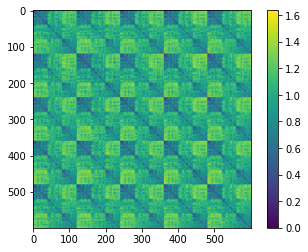

In [5]:
#test on KDEF dataset subset A (note that this is described as dataset B in the paper, and vice versa the dataset that is described as dataset A in the paper is named dataset B in the code)
#open subset_A
Dataset_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_A_with_id_expression_direction.pkl', "rb"))

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_A = []
model.eval()
with torch.no_grad():
    for idx, row in Dataset_A.iterrows():
        image = Image.open(Dataset_A['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        qvalues, reconstruction, mu, logVar = model(image[None, :].cuda())
        mu_list_A.append(mu[0, :])
A_mus = torch.stack((mu_list_A))

#save mu
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/UNSUP+RL/KDEF_test_results_AB/"
with open(path + 'mu_values_A.pkl', 'wb') as pickle_out:
     pickle.dump(A_mus, pickle_out)      
    
Dataset_A['mu_A'] = A_mus.cpu().detach()
Dataset_A_with_mu = Dataset_A  

#average the L and R         
Dataset_A_with_mu["new_direction"] = np.where((Dataset_A_with_mu["direction"].values == "HR") | (Dataset_A_with_mu["direction"] == "HL"), 
         "H", 
         np.where((Dataset_A_with_mu["direction"].values == "FR") | (Dataset_A_with_mu["direction"] == "FL"), 
         "F", 
         Dataset_A_with_mu["direction"].values))        
         

group_index = Dataset_A_with_mu.agg('{0[expression]} and {0[new_direction]} and {0[id]}'.format, axis = 1)

ids = np.unique(group_index)
g_mean = np.array([np.mean(A_mus.cpu().detach().numpy()[group_index == i, 0:], axis = 0) for i in ids])

df_LR_ave = pd.DataFrame(data = np.array(list(map(lambda x : np.str.split(x, sep = " and "), ids))))
df_LR_ave.columns = ["expression", "direction", "id"]
df_LR_ave['mu_A'] = g_mean.tolist()
                
#label everything
dictionary_emotion_A = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
df_LR_ave['emotionlabel_A'] = df_LR_ave['expression'].map(dictionary_emotion_A)

dictionary_view_A = {'F' : 0, 'H' : 1, 'S' : 2}
df_LR_ave['viewlabel_A'] = df_LR_ave['direction'].map(dictionary_view_A)

dictionary_id_A = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AF06' : 4, 'AF07' : 5, 'AF09' : 6, 'AF13' : 7, 'AF14' : 8, 'AF16' : 9,
 'AF20' : 10, 'AF21' : 11, 'AF22' : 12, 'AF24' : 13, 'AF25': 14, 'AF28' : 15, 'AF29' : 16, 'AF30' : 17, 'AF32' : 18, 
 'AF33' : 19, 'AM01' : 20, 'AM05' : 21, 'AM06' : 22, 'AM08' : 23, 'AM09' : 24, 'AM10' : 25, 'AM11' : 26, 'AM13' : 27,
 'AM14' : 28, 'AM15' : 29, 'AM16' : 30, 'AM22' : 31, 'AM23' : 32, 'AM24' : 33, 'AM25' : 34, 'AM28' : 35, 'AM29' : 36,
 'AM30' : 37, 'AM31' : 38, 'AM35' : 39}
df_LR_ave['idlabel_A'] = df_LR_ave['id'].map(dictionary_id_A)

#order everything
New_Data_A = df_LR_ave.sort_values(by = ['emotionlabel_A', 'viewlabel_A', 'idlabel_A'])
#reset the index and save the dataframe in New_Data_A_with_mu
New_Data_A_with_mu = New_Data_A.reset_index(drop = True)  

# create array features
array_features_A = [New_Data_A_with_mu['mu_A'][0]]
for i in range(1, New_Data_A_with_mu.shape[0]):
    array_features_A = np.concatenate((array_features_A, [New_Data_A_with_mu['mu_A'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_A, axis = 0)
centered_data = array_features_A - average_vector

# attach centered_feature
New_Data_A_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

l_A = [None] * 600
for _ in range (len(New_Data_A_with_mu)):
    l_A [New_Data_A_with_mu.iloc[_]['idlabel_A'] + 
         40 * New_Data_A_with_mu.iloc[_]['viewlabel_A'] + 
         40 * 3 * New_Data_A_with_mu.iloc[_]['emotionlabel_A']] = New_Data_A_with_mu.iloc[_]['centered_feature']      

RDM_A = 1 - np.corrcoef(l_A)      

plt.imshow(RDM_A) ## note that this is named RDM B in the paper
plt.colorbar()

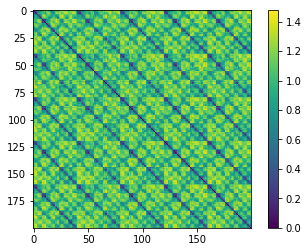

In [6]:
Dataset_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_B_with_id_expression_direction.pkl', "rb"))   

KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])

mu_list_B = []
model.eval()
with torch.no_grad():
    for idx, row in Dataset_B.iterrows():
        image = Image.open(Dataset_B['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        qvalues, reconstruction, mu, logVar = model(image[None, :].cuda())
        mu_list_B.append(mu[0, :])      
B_mus = torch.stack((mu_list_B))

#save mu
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/UNSUP+RL/KDEF_test_results_AB/"
with open(path + 'mu_values_B.pkl', 'wb') as pickle_out:
     pickle.dump(B_mus, pickle_out)

#label everything
dictionary_emotion = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
Dataset_B['emotionlabel'] = Dataset_B['expression'].map(dictionary_emotion)

dictionary_view = {'FL' : 0, 'FR' : 1, 'HL' : 2, 'HR' : 3, 'S' : 4}
Dataset_B['viewlabel'] = Dataset_B['direction'].map(dictionary_view)

dictionary_id = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AM08' : 4, 'AM10' : 5, 'AM11' : 6, 'AM25': 7}
Dataset_B['idlabel'] = Dataset_B['id'].map(dictionary_id)

#add mu to the dataset
Dataset_B['mu_B'] = B_mus.cpu().detach()

#order everything
New_Data_B = Dataset_B.sort_values(by = ['emotionlabel', 'viewlabel', 'idlabel'])
#reset the index and save the dataframe in New_Data_B_with_mu
New_Data_B_with_mu = New_Data_B.reset_index(drop = True)

# create array features
array_features_B = [New_Data_B_with_mu['mu_B'][0]]
for i in range(1, New_Data_B_with_mu.shape[0]):
    array_features_B = np.concatenate((array_features_B, [New_Data_B_with_mu['mu_B'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_B, axis = 0)
centered_data = array_features_B - average_vector

# attach centered_feature
New_Data_B_with_mu['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

# create RDM
l = [None] * 200
for _ in range (len(New_Data_B_with_mu)):
    l [New_Data_B_with_mu.iloc[_]['idlabel'] + 
       8 * New_Data_B_with_mu.iloc[_]['viewlabel'] + 
       8 * 5 * New_Data_B_with_mu.iloc[_]['emotionlabel']] = New_Data_B_with_mu.iloc[_]['centered_feature']

RDM_B = 1 - np.corrcoef(l)

plt.imshow(RDM_B) ## note that this is named RDM A in the paper
plt.colorbar()

In [7]:
#save RDM value
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/UNSUP+RL/KDEF_test_results_AB/"
with open(path + 'RDM_value_A.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_A, pickle_out)
        
with open(path + 'RDM_value_B.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_B, pickle_out)

In [3]:
# open RDMs for KDEF A & B
UNSUP_RL_RDM_value_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/UNSUP+RL/KDEF_test_results_AB/RDM_value_A.pkl',"rb"))
v_UNSUP_RL_RDM_A = UNSUP_RL_RDM_value_A[np.triu_indices(UNSUP_RL_RDM_value_A.shape[0], 1)]

UNSUP_RL_RDM_value_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/UNSUP+RL/KDEF_test_results_AB/RDM_value_B.pkl',"rb"))
v_UNSUP_RL_RDM_B = UNSUP_RL_RDM_value_B[np.triu_indices(UNSUP_RL_RDM_value_B.shape[0], 1)]

In [4]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p16/'
vA_p16_rdms = []
v_vA_p16_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p16_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p16_rdms)):
    vector = vA_p16_rdms[i][np.triu_indices(vA_p16_rdms[i].shape[0], 1)]
    v_vA_p16_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p16 = []
for i in range (len(v_vA_p16_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p16.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p16_rdms[i]))
    
corr, _ = kendalltau_UNSUP_RL_and_vA_p16[0]
print('subset A UNSUP_RL and p16_e90_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p16[1]
print('subset A UNSUP_RL and p16_e90_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p16[2]
print('subset A UNSUP_RL and p16_e90_wind6 kendalltau: %.5f' % corr)

subset A UNSUP_RL and p16_e90_wind4 kendalltau: 0.03594
subset A UNSUP_RL and p16_e90_wind5 kendalltau: 0.02588
subset A UNSUP_RL and p16_e90_wind6 kendalltau: 0.00898


In [5]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p23/'
vA_p23_rdms = []
v_vA_p23_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p23_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p23_rdms)):
    vector = vA_p23_rdms[i][np.triu_indices(vA_p23_rdms[i].shape[0], 1)]
    v_vA_p23_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p23 = []
for i in range (len(v_vA_p23_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p23.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p23_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vA_p23[0]
print('subset A UNSUP_RL and p23_wind4 kendalltau: 0')
corr, _ = kendalltau_UNSUP_RL_and_vA_p23[1]
print('subset A UNSUP_RL and p23_wind5 kendalltau: 0')
corr, _ = kendalltau_UNSUP_RL_and_vA_p23[2]
print('subset A UNSUP_RL and p23_wind6 kendalltau: 0')

subset A UNSUP_RL and p23_wind4 kendalltau: 0
subset A UNSUP_RL and p23_wind5 kendalltau: 0
subset A UNSUP_RL and p23_wind6 kendalltau: 0


In [6]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p27/'
vA_p27_rdms = []
v_vA_p27_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p27_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p27_rdms)):
    vector = vA_p27_rdms[i][np.triu_indices(vA_p27_rdms[i].shape[0], 1)]
    v_vA_p27_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p27 = []
for i in range (len(v_vA_p27_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p27.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p27_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vA_p27[0]
print('subset A UNSUP_RL and p27_e100_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[1]
print('subset A UNSUP_RL and p27_e100_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[2]
print('subset A UNSUP_RL and p27_e100_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[3]
print('subset A UNSUP_RL and p27_e53_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[4]
print('subset A UNSUP_RL and p27_e53_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[5]
print('subset A UNSUP_RL and p27_e53_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[6]
print('subset A UNSUP_RL and p27_e60_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[7]
print('subset A UNSUP_RL and p27_e60_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[8]
print('subset A UNSUP_RL and p27_e60_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[9]
print('subset A UNSUP_RL and p27_e61_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[10]
print('subset A UNSUP_RL and p27_e61_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[11]
print('subset A UNSUP_RL and p27_e61_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[12]
print('subset A UNSUP_RL and p27_e62_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[13]
print('subset A UNSUP_RL and p27_e62_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p27[14]
print('subset A UNSUP_RL and p27_e62_wind6 kendalltau: %.5f' % corr)

subset A UNSUP_RL and p27_e100_wind4 kendalltau: 0.04845
subset A UNSUP_RL and p27_e100_wind5 kendalltau: 0.03104
subset A UNSUP_RL and p27_e100_wind6 kendalltau: 0.01045
subset A UNSUP_RL and p27_e53_wind4 kendalltau: 0.06033
subset A UNSUP_RL and p27_e53_wind5 kendalltau: 0.08200
subset A UNSUP_RL and p27_e53_wind6 kendalltau: 0.04661
subset A UNSUP_RL and p27_e60_wind4 kendalltau: 0.02528
subset A UNSUP_RL and p27_e60_wind5 kendalltau: 0.03826
subset A UNSUP_RL and p27_e60_wind6 kendalltau: 0.00905
subset A UNSUP_RL and p27_e61_wind4 kendalltau: 0.01370
subset A UNSUP_RL and p27_e61_wind5 kendalltau: 0.05113
subset A UNSUP_RL and p27_e61_wind6 kendalltau: 0.02722
subset A UNSUP_RL and p27_e62_wind4 kendalltau: 0.04450
subset A UNSUP_RL and p27_e62_wind5 kendalltau: 0.04915
subset A UNSUP_RL and p27_e62_wind6 kendalltau: 0.03894


In [7]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p28/'
vA_p28_rdms = []
v_vA_p28_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p28_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p28_rdms)):
    vector = vA_p28_rdms[i][np.triu_indices(vA_p28_rdms[i].shape[0], 1)]
    v_vA_p28_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p28 = []
for i in range (len(v_vA_p28_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p28.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p28_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vA_p28[0]
print('subset A UNSUP_RL and p28_e85_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p28[1]
print('subset A UNSUP_RL and p28_e85_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p28[2]
print('subset A UNSUP_RL and p28_e85_wind6 kendalltau: %.5f' % corr)

subset A UNSUP_RL and p28_e85_wind4 kendalltau: 0.04938
subset A UNSUP_RL and p28_e85_wind5 kendalltau: 0.00890
subset A UNSUP_RL and p28_e85_wind6 kendalltau: 0.00697


In [8]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p30/'
vA_p30_rdms = []
v_vA_p30_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p30_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p30_rdms)):
    vector = vA_p30_rdms[i][np.triu_indices(vA_p30_rdms[i].shape[0], 1)]
    v_vA_p30_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p30 = []
for i in range (len(v_vA_p30_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p30.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p30_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vA_p30[0]
print('subset A UNSUP_RL and p30_e8_wind4 kendalltau: 0')
corr, _ = kendalltau_UNSUP_RL_and_vA_p30[1]
print('subset A UNSUP_RL and p30_e8_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p30[2]
print('subset A UNSUP_RL and p30_e8_wind6 kendalltau: %.5f' % corr)

subset A UNSUP_RL and p30_e8_wind4 kendalltau: 0
subset A UNSUP_RL and p30_e8_wind5 kendalltau: 0.00111
subset A UNSUP_RL and p30_e8_wind6 kendalltau: 0.00127


In [9]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p34/'
vA_p34_rdms = []
v_vA_p34_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p34_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p34_rdms)):
    vector = vA_p34_rdms[i][np.triu_indices(vA_p34_rdms[i].shape[0], 1)]
    v_vA_p34_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p34 = []
for i in range (len(v_vA_p34_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p34.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p34_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vA_p34[0]
print('subset A UNSUP_RL and p34_e23_wind4 kendalltau: 0')
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[1]
print('subset A UNSUP_RL and p34_e23_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[2]
print('subset A UNSUP_RL and p34_e23_wind6 kendalltau: 0')
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[3]
print('subset A UNSUP_RL and p34_e42_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[4]
print('subset A UNSUP_RL and p34_e42_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[5]
print('subset A UNSUP_RL and p34_e42_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[6]
print('subset A UNSUP_RL and p34_e44_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[7]
print('subset A UNSUP_RL and p34_e44_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[8]
print('subset A UNSUP_RL and p34_e44_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[9]
print('subset A UNSUP_RL and p43_e43_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[10]
print('subset A UNSUP_RL and p43_e43_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p34[11]
print('subset A UNSUP_RL and p43_e43_wind6 kendalltau: %.5f' % corr)

subset A UNSUP_RL and p34_e23_wind4 kendalltau: 0
subset A UNSUP_RL and p34_e23_wind5 kendalltau: 0.00033
subset A UNSUP_RL and p34_e23_wind6 kendalltau: 0
subset A UNSUP_RL and p34_e42_wind4 kendalltau: 0.01937
subset A UNSUP_RL and p34_e42_wind5 kendalltau: 0.00644
subset A UNSUP_RL and p34_e42_wind6 kendalltau: 0.00216
subset A UNSUP_RL and p34_e44_wind4 kendalltau: 0.02427
subset A UNSUP_RL and p34_e44_wind5 kendalltau: 0.01864
subset A UNSUP_RL and p34_e44_wind6 kendalltau: 0.00368
subset A UNSUP_RL and p43_e43_wind4 kendalltau: 0.08313
subset A UNSUP_RL and p43_e43_wind5 kendalltau: 0.03725
subset A UNSUP_RL and p43_e43_wind6 kendalltau: 0.00576


In [10]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p36/'
vA_p36_rdms = []
v_vA_p36_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p36_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p36_rdms)):
    vector = vA_p36_rdms[i][np.triu_indices(vA_p36_rdms[i].shape[0], 1)]
    v_vA_p36_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p36 = []
for i in range (len(v_vA_p36_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p36.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p36_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vA_p36[0]
print('subset A UNSUP_RL and p36_e64_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[1]
print('subset A UNSUP_RL and p36_e64_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[2]
print('subset A UNSUP_RL and p36_e64_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[3]
print('subset A UNSUP_RL and p36_e69_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[4]
print('subset A UNSUP_RL and p36_e69_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[5]
print('subset A UNSUP_RL and p36_e69_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[6]
print('subset A UNSUP_RL and p36_e70_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[7]
print('subset A UNSUP_RL and p36_e70_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p36[8]
print('subset A UNSUP_RL and p36_e70_wind6 kendalltau: %.5f' % corr)

subset A UNSUP_RL and p36_e64_wind4 kendalltau: 0.12227
subset A UNSUP_RL and p36_e64_wind5 kendalltau: 0.08765
subset A UNSUP_RL and p36_e64_wind6 kendalltau: 0.05020
subset A UNSUP_RL and p36_e69_wind4 kendalltau: 0.00377
subset A UNSUP_RL and p36_e69_wind5 kendalltau: 0.00644
subset A UNSUP_RL and p36_e69_wind6 kendalltau: 0.00672
subset A UNSUP_RL and p36_e70_wind4 kendalltau: 0.00227
subset A UNSUP_RL and p36_e70_wind5 kendalltau: 0.00644
subset A UNSUP_RL and p36_e70_wind6 kendalltau: 0.00153


In [11]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p39/'
vA_p39_rdms = []
v_vA_p39_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p39_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p39_rdms)):
    vector = vA_p39_rdms[i][np.triu_indices(vA_p39_rdms[i].shape[0], 1)]
    v_vA_p39_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vA_p39 = []
for i in range (len(v_vA_p39_rdms)):   
    kendalltau_UNSUP_RL_and_vA_p39.append(stats.kendalltau(v_UNSUP_RL_RDM_A, v_vA_p39_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vA_p39[0]
print('subset A UNSUP_RL and p39_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vA_p39[1]
print('subset A UNSUP_RL and p39_wind5 kendalltau: 0')
corr, _ = kendalltau_UNSUP_RL_and_vA_p39[2]
print('subset A UNSUP_RL and p39_wind6 kendalltau: 0')

subset A UNSUP_RL and p39_wind4 kendalltau: 0.00022
subset A UNSUP_RL and p39_wind5 kendalltau: 0
subset A UNSUP_RL and p39_wind6 kendalltau: 0


In [12]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/p41/'
vB_p41_rdms = []
v_vB_p41_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p41_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p41_rdms)):
    vector = vB_p41_rdms[i][np.triu_indices(vB_p41_rdms[i].shape[0], 1)]
    v_vB_p41_rdms.append(vector)
    
kendalltau_UNSUP_RL_and_vB_p41 = []
for i in range (len(v_vB_p41_rdms)):   
    kendalltau_UNSUP_RL_and_vB_p41.append(stats.kendalltau(v_UNSUP_RL_RDM_B, v_vB_p41_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vB_p41[1]
print('subset B UNSUP_RL and p41_e10_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[2]
print('subset B UNSUP_RL and p41_e10_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[3]
print('subset B UNSUP_RL and p41_e10_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[7]
print('subset B UNSUP_RL and p41_e11_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[8]
print('subset B UNSUP_RL and p41_e11_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[9]
print('subset B UNSUP_RL and p41_e11_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[13]
print('subset B UNSUP_RL and p41_e12_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[14]
print('subset B UNSUP_RL and p41_e12_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[15]
print('subset B UNSUP_RL and p41_e12_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[19]
print('subset B UNSUP_RL and p41_e2_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[20]
print('subset B UNSUP_RL and p41_e2_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[21]
print('subset B UNSUP_RL and p41_e2_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[25]
print('subset B UNSUP_RL and p41_e24_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[26]
print('subset B UNSUP_RL and p41_e24_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[27]
print('subset B UNSUP_RL and p41_e24_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[31]
print('subset B UNSUP_RL and p41_e9_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[32]
print('subset B UNSUP_RL and p41_e9_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p41[33]
print('subset B UNSUP_RL and p41_e9_wind6 kendalltau: %.5f' % corr)

subset B UNSUP_RL and p41_e10_wind4 kendalltau: 0.21457
subset B UNSUP_RL and p41_e10_wind5 kendalltau: 0.17973
subset B UNSUP_RL and p41_e10_wind6 kendalltau: 0.02775
subset B UNSUP_RL and p41_e11_wind4 kendalltau: 0.13854
subset B UNSUP_RL and p41_e11_wind5 kendalltau: 0.09653
subset B UNSUP_RL and p41_e11_wind6 kendalltau: 0.01055
subset B UNSUP_RL and p41_e12_wind4 kendalltau: 0.07143
subset B UNSUP_RL and p41_e12_wind5 kendalltau: 0.03665
subset B UNSUP_RL and p41_e12_wind6 kendalltau: 0.02099
subset B UNSUP_RL and p41_e2_wind4 kendalltau: 0.13757
subset B UNSUP_RL and p41_e2_wind5 kendalltau: 0.07159
subset B UNSUP_RL and p41_e2_wind6 kendalltau: 0.00192
subset B UNSUP_RL and p41_e24_wind4 kendalltau: 0.08562
subset B UNSUP_RL and p41_e24_wind5 kendalltau: 0.03645
subset B UNSUP_RL and p41_e24_wind6 kendalltau: 0.00738
subset B UNSUP_RL and p41_e9_wind4 kendalltau: 0.18207
subset B UNSUP_RL and p41_e9_wind5 kendalltau: 0.10782
subset B UNSUP_RL and p41_e9_wind6 kendalltau: 0.0140

In [13]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/fusiform_reliable/p47/'
vB_p47_rdms = []
v_vB_p47_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p47_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p47_rdms)):
    vector = vB_p47_rdms[i][np.triu_indices(vB_p47_rdms[i].shape[0], 1)]
    v_vB_p47_rdms.append(vector)

kendalltau_UNSUP_RL_and_vB_p47 = []
for i in range (len(v_vB_p47_rdms)):   
    kendalltau_UNSUP_RL_and_vB_p47.append(stats.kendalltau(v_UNSUP_RL_RDM_B, v_vB_p47_rdms[i]))

corr, _ = kendalltau_UNSUP_RL_and_vB_p47[1]
print('subset B UNSUP_RL and p47_e34_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p47[2]
print('subset B UNSUP_RL and p47_e34_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_UNSUP_RL_and_vB_p47[3]
print('subset B UNSUP_RL and p47_e34_wind6 kendalltau: %.5f' % corr)

subset B UNSUP_RL and p47_e34_wind4 kendalltau: 0.15896
subset B UNSUP_RL and p47_e34_wind5 kendalltau: 0.08683
subset B UNSUP_RL and p47_e34_wind6 kendalltau: 0.01203


In [23]:
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/UNSUP+RL/KDEF_test_results_AB/kendalltaus/"

UNSUP_RL_tau_wind4 = np.array([kendalltau_UNSUP_RL_and_vA_p16[0][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p27[0][0],
                            kendalltau_UNSUP_RL_and_vA_p27[3][0],
                            kendalltau_UNSUP_RL_and_vA_p27[6][0],
                            kendalltau_UNSUP_RL_and_vA_p27[9][0],
                            kendalltau_UNSUP_RL_and_vA_p27[12][0],
                            kendalltau_UNSUP_RL_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_UNSUP_RL_and_vA_p34[3][0],
                            kendalltau_UNSUP_RL_and_vA_p34[6][0],
                            kendalltau_UNSUP_RL_and_vA_p34[9][0],
                            kendalltau_UNSUP_RL_and_vA_p36[0][0],
                            kendalltau_UNSUP_RL_and_vA_p36[3][0],
                            kendalltau_UNSUP_RL_and_vA_p36[6][0],
                            kendalltau_UNSUP_RL_and_vA_p39[0][0],
                            kendalltau_UNSUP_RL_and_vB_p41[1][0],
                            kendalltau_UNSUP_RL_and_vB_p41[7][0],
                            kendalltau_UNSUP_RL_and_vB_p41[13][0],
                            kendalltau_UNSUP_RL_and_vB_p41[19][0],
                            kendalltau_UNSUP_RL_and_vB_p41[25][0],
                            kendalltau_UNSUP_RL_and_vB_p41[31][0],
                            kendalltau_UNSUP_RL_and_vB_p47[1][0]])

UNSUP_RL_tau_wind4_mean = np.mean(UNSUP_RL_tau_wind4)
UNSUP_RL_tau_wind4_sem = sem(UNSUP_RL_tau_wind4)

with open(path + 'UNSUP_RL_tau_wind4.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind4, pickle_out)      
with open(path + 'UNSUP_RL_tau_wind4_mean.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind4_mean, pickle_out) 
with open(path + 'UNSUP_RL_tau_wind4_sem.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind4_sem, pickle_out) 


UNSUP_RL_tau_wind5 = np.array([kendalltau_UNSUP_RL_and_vA_p16[1][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p27[1][0],
                            kendalltau_UNSUP_RL_and_vA_p27[4][0],
                            kendalltau_UNSUP_RL_and_vA_p27[7][0],
                            kendalltau_UNSUP_RL_and_vA_p27[10][0],
                            kendalltau_UNSUP_RL_and_vA_p27[13][0],
                            kendalltau_UNSUP_RL_and_vA_p28[1][0],
                            kendalltau_UNSUP_RL_and_vA_p30[1][0],
                            kendalltau_UNSUP_RL_and_vA_p34[1][0],
                            kendalltau_UNSUP_RL_and_vA_p34[4][0],
                            kendalltau_UNSUP_RL_and_vA_p34[7][0],
                            kendalltau_UNSUP_RL_and_vA_p34[10][0],
                            kendalltau_UNSUP_RL_and_vA_p36[1][0],
                            kendalltau_UNSUP_RL_and_vA_p36[4][0],
                            kendalltau_UNSUP_RL_and_vA_p36[7][0],
                            0,
                            kendalltau_UNSUP_RL_and_vB_p41[2][0],
                            kendalltau_UNSUP_RL_and_vB_p41[8][0],
                            kendalltau_UNSUP_RL_and_vB_p41[14][0],
                            kendalltau_UNSUP_RL_and_vB_p41[20][0],
                            kendalltau_UNSUP_RL_and_vB_p41[26][0],
                            kendalltau_UNSUP_RL_and_vB_p41[32][0],
                            kendalltau_UNSUP_RL_and_vB_p47[2][0]])

UNSUP_RL_tau_wind5_mean = np.mean(UNSUP_RL_tau_wind5)
UNSUP_RL_tau_wind5_sem = sem(UNSUP_RL_tau_wind5)

with open(path + 'UNSUP_RL_tau_wind5.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind5, pickle_out)      
with open(path + 'UNSUP_RL_tau_wind5_mean.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind5_mean, pickle_out) 
with open(path + 'UNSUP_RL_tau_wind5_sem.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind5_sem, pickle_out) 


UNSUP_RL_tau_wind6 = np.array([kendalltau_UNSUP_RL_and_vA_p16[2][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p27[2][0],
                            kendalltau_UNSUP_RL_and_vA_p27[5][0],
                            kendalltau_UNSUP_RL_and_vA_p27[8][0],
                            kendalltau_UNSUP_RL_and_vA_p27[11][0],
                            kendalltau_UNSUP_RL_and_vA_p27[14][0],
                            kendalltau_UNSUP_RL_and_vA_p28[2][0],
                            kendalltau_UNSUP_RL_and_vA_p30[2][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p34[5][0],
                            kendalltau_UNSUP_RL_and_vA_p34[8][0],
                            kendalltau_UNSUP_RL_and_vA_p34[11][0],
                            kendalltau_UNSUP_RL_and_vA_p36[2][0],
                            kendalltau_UNSUP_RL_and_vA_p36[5][0],
                            kendalltau_UNSUP_RL_and_vA_p36[8][0],
                            0,
                            kendalltau_UNSUP_RL_and_vB_p41[3][0],
                            kendalltau_UNSUP_RL_and_vB_p41[9][0],
                            kendalltau_UNSUP_RL_and_vB_p41[15][0],
                            kendalltau_UNSUP_RL_and_vB_p41[21][0],
                            kendalltau_UNSUP_RL_and_vB_p41[27][0],
                            kendalltau_UNSUP_RL_and_vB_p41[33][0],
                            kendalltau_UNSUP_RL_and_vB_p47[3][0]])

UNSUP_RL_tau_wind6_mean = np.mean(UNSUP_RL_tau_wind6)
UNSUP_RL_tau_wind6_sem = sem(UNSUP_RL_tau_wind6)

with open(path + 'UNSUP_RL_tau_wind6.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind6, pickle_out)      
with open(path + 'UNSUP_RL_tau_wind6_mean.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind6_mean, pickle_out) 
with open(path + 'UNSUP_RL_tau_wind6_sem.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL_tau_wind6_sem, pickle_out) 

In [16]:
d_UNSUP_RL_win_4 = {'value': [kendalltau_UNSUP_RL_and_vA_p16[0][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p27[0][0],
                            kendalltau_UNSUP_RL_and_vA_p27[3][0],
                            kendalltau_UNSUP_RL_and_vA_p27[6][0],
                            kendalltau_UNSUP_RL_and_vA_p27[9][0],
                            kendalltau_UNSUP_RL_and_vA_p27[12][0],
                            kendalltau_UNSUP_RL_and_vA_p28[0][0],
                            0,
                            0,
                            kendalltau_UNSUP_RL_and_vA_p34[3][0],
                            kendalltau_UNSUP_RL_and_vA_p34[6][0],
                            kendalltau_UNSUP_RL_and_vA_p34[9][0],
                            kendalltau_UNSUP_RL_and_vA_p36[0][0],
                            kendalltau_UNSUP_RL_and_vA_p36[3][0],
                            kendalltau_UNSUP_RL_and_vA_p36[6][0],
                            kendalltau_UNSUP_RL_and_vA_p39[0][0],
                            kendalltau_UNSUP_RL_and_vB_p41[1][0],
                            kendalltau_UNSUP_RL_and_vB_p41[7][0],
                            kendalltau_UNSUP_RL_and_vB_p41[13][0],
                            kendalltau_UNSUP_RL_and_vB_p41[19][0],
                            kendalltau_UNSUP_RL_and_vB_p41[25][0],
                            kendalltau_UNSUP_RL_and_vB_p41[31][0],
                            kendalltau_UNSUP_RL_and_vB_p47[1][0]], 
     'window': ['window4'] * len(UNSUP_RL_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['UNSUP_RL'] * len(UNSUP_RL_tau_wind4)}

UNSUP_RL_win_4 = pd.DataFrame(data = d_UNSUP_RL_win_4)

d_UNSUP_RL_win_5 = {'value': [kendalltau_UNSUP_RL_and_vA_p16[1][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p27[1][0],
                            kendalltau_UNSUP_RL_and_vA_p27[4][0],
                            kendalltau_UNSUP_RL_and_vA_p27[7][0],
                            kendalltau_UNSUP_RL_and_vA_p27[10][0],
                            kendalltau_UNSUP_RL_and_vA_p27[13][0],
                            kendalltau_UNSUP_RL_and_vA_p28[1][0],
                            kendalltau_UNSUP_RL_and_vA_p30[1][0],
                            kendalltau_UNSUP_RL_and_vA_p34[1][0],
                            kendalltau_UNSUP_RL_and_vA_p34[4][0],
                            kendalltau_UNSUP_RL_and_vA_p34[7][0],
                            kendalltau_UNSUP_RL_and_vA_p34[10][0],
                            kendalltau_UNSUP_RL_and_vA_p36[1][0],
                            kendalltau_UNSUP_RL_and_vA_p36[4][0],
                            kendalltau_UNSUP_RL_and_vA_p36[7][0],
                            0,
                            kendalltau_UNSUP_RL_and_vB_p41[2][0],
                            kendalltau_UNSUP_RL_and_vB_p41[8][0],
                            kendalltau_UNSUP_RL_and_vB_p41[14][0],
                            kendalltau_UNSUP_RL_and_vB_p41[20][0],
                            kendalltau_UNSUP_RL_and_vB_p41[26][0],
                            kendalltau_UNSUP_RL_and_vB_p41[32][0],
                            kendalltau_UNSUP_RL_and_vB_p47[2][0]],
     'window': ['window5'] * len(UNSUP_RL_tau_wind5), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['UNSUP_RL'] * len(UNSUP_RL_tau_wind5)}

UNSUP_RL_win_5 = pd.DataFrame(data = d_UNSUP_RL_win_5)

d_UNSUP_RL_win_6 = {'value': [kendalltau_UNSUP_RL_and_vA_p16[2][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p27[2][0],
                            kendalltau_UNSUP_RL_and_vA_p27[5][0],
                            kendalltau_UNSUP_RL_and_vA_p27[8][0],
                            kendalltau_UNSUP_RL_and_vA_p27[11][0],
                            kendalltau_UNSUP_RL_and_vA_p27[14][0],
                            kendalltau_UNSUP_RL_and_vA_p28[2][0],
                            kendalltau_UNSUP_RL_and_vA_p30[2][0],
                            0,
                            kendalltau_UNSUP_RL_and_vA_p34[5][0],
                            kendalltau_UNSUP_RL_and_vA_p34[8][0],
                            kendalltau_UNSUP_RL_and_vA_p34[11][0],
                            kendalltau_UNSUP_RL_and_vA_p36[2][0],
                            kendalltau_UNSUP_RL_and_vA_p36[5][0],
                            kendalltau_UNSUP_RL_and_vA_p36[8][0],
                            0,
                            kendalltau_UNSUP_RL_and_vB_p41[3][0],
                            kendalltau_UNSUP_RL_and_vB_p41[9][0],
                            kendalltau_UNSUP_RL_and_vB_p41[15][0],
                            kendalltau_UNSUP_RL_and_vB_p41[21][0],
                            kendalltau_UNSUP_RL_and_vB_p41[27][0],
                            kendalltau_UNSUP_RL_and_vB_p41[33][0],
                            kendalltau_UNSUP_RL_and_vB_p47[3][0]],
     'window': ['window6'] * len(UNSUP_RL_tau_wind6), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['UNSUP_RL'] * len(UNSUP_RL_tau_wind6)}

UNSUP_RL_win_6 = pd.DataFrame(data = d_UNSUP_RL_win_6)

UNSUP_RL = pd.concat([UNSUP_RL_win_4, UNSUP_RL_win_5, UNSUP_RL_win_6])
UNSUP_RL

,value,window,subject,model
0,0.035938,window4,16,UNSUP_RL
1,0.000000,window4,23,UNSUP_RL
2,0.048453,window4,27,UNSUP_RL
3,0.060328,window4,27,UNSUP_RL
4,0.025275,window4,27,UNSUP_RL
...,...,...,...,...
19,0.020993,window6,41,UNSUP_RL
20,0.001919,window6,41,UNSUP_RL
21,0.007382,window6,41,UNSUP_RL
22,0.014071,window6,41,UNSUP_RL


In [17]:
path = "/data/zhouabx/KDEF/KDEF_RDM_new/2023_Oct_RDMs/UNSUP+RL/UNSUP_RL_ttest_df/"
with open(path + 'UNSUP_RL.pkl', 'wb') as pickle_out:
     pickle.dump(UNSUP_RL, pickle_out)      